In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
fb = pd.read_csv('./results_year.csv')
fb.head()

,country,year,neutral,home_win,away_win,games_played,goal_diff,win_rate
0,Austria,2010,0,1,0,4,-1,0.250000
1,Austria,2011,0,1,0,6,-8,0.166667
2,Austria,2012,0,1,0,3,1,0.333333
3,Austria,2013,0,1,0,4,-5,0.250000
4,Austria,2014,0,0,0,1,0,0.000000


In [4]:
sj = pd.read_csv('./jobs/sports_jobs.csv')
sj.head()

,country,year,employed
0,Austria,2011,251000
1,Austria,2012,240000
2,Austria,2013,258000
3,Austria,2014,278000
4,Austria,2015,359000


In [5]:
imm = pd.read_csv('./immigration/immigration.csv')
imm.head()

,Unnamed: 0,country,year,immigration
0,0,Belgium,2010,135281.0
1,1,Bulgaria,2010,NaN
2,2,Czechia,2010,48317.0
3,3,Denmark,2010,52236.0
4,4,Germany,2010,404055.0


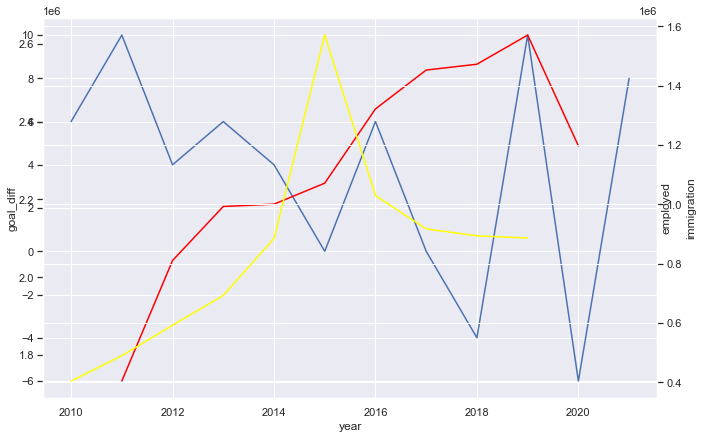

In [9]:
# clean data
country = "Germany"
s_fb = fb[(fb["country"] == country)]
s_sj = sj[sj["country"] == country]
s_imm = imm[imm["country"] == country]
# fball plot
lp1 = sns.lineplot(data=s_fb, x="year", y="goal_diff", hue="country")
lp1.legend_ = None
# employment plot
ax2 = plt.twinx()
lp2 = sns.lineplot(data=s_sj, x="year", y="employed", palette=["red"], hue="country", ax=ax2)
lp2.legend_ = None
# immigration plot
ax3 = plt.twinx()
lp3 = sns.lineplot(data=s_imm, x="year", y="immigration", palette=["yellow"], hue="country", ax=ax3)
lp3.legend_ = None
# change size
sns.set(rc={'figure.figsize':(11,7)})
lp2.grid(False)

